# DevDay 01: A real-world dataset

In [1]:
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt 

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("."), "..")))
#
from data.electricity_consumption import energy_demand
from data.dataset import Dataset

## Load and preprocess the dataset
Made simple due to loading module

In [3]:
# load the data
dataset_object = energy_demand(zone=["CT"], scale=False)

# get the data from the Dataset object
data = dataset_object.values

INFO:root:Imputing data for columns ['CT']
INFO:root:columns present: Index(['CT'], dtype='object', name='zone')
INFO:root:Shape of dataframe before imputation: (5175, 1)


Imputing data


In [4]:
# show the data
data.head()

zone,CT
ts,
2003-03-02,3254.000000
2003-03-09,3328.714286
2003-03-16,3268.714286
2003-03-23,2805.571429
2003-03-30,2732.285714


In [23]:
# What are the data types?
data.dtypes



zone
CT    float64
dtype: object

In [20]:
# Check that the index of the Pandas DataFrame is a DatetimeIndex

print(f"Type of index: {type(data.index)}")

# show us what that looks like
print(data.index[:5])

Type of index: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2003-03-02', '2003-03-09', '2003-03-16', '2003-03-23',
               '2003-03-30'],
              dtype='datetime64[ns]', name='ts', freq='W-SUN')


In [22]:
# show us the frequency of the data
print(f"Frequency of data: {data.index.freq}")

# What does weekday=6 mean?
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.weekday.html
data.index.weekday[:5]

Frequency of data: <Week: weekday=6>


Int64Index([6, 6, 6, 6, 6], dtype='int64', name='ts')

## Splitting into training and test sets

**Why We Don't Shuffle Time Series Data Before Splitting**

In time series analysis, it's important to maintain the temporal order of the data when splitting into training and testing sets. This is because the inherent chronological order helps capture underlying patterns and trends that are essential for accurate forecasting.

Shuffling time series data before splitting disrupts this order and compromises the model's ability to accurately predict future events based on historical information. Therefore, when working with time series data, ensure that the training set consists of the initial, contiguous portion of the data, and the testing set is the subsequent, contiguous portion. This method preserves the historical context necessary for the model to make accurate predictions.

In [ ]:
# Here we split the data into training and test sets
# We will use the first 80% of the data for training
# and the last 20% for testing

# get the length of the data
length = len(data)

# get the index of the last training data point
last_training_index = int(length * 0.8)

# get the index of the first test data point
first_test_index = last_training_index + 1

# get the training data
training_data = data.iloc[:last_training_index]

# get the test data
test_data = data.iloc[first_test_index:]


In [ ]:
# or a quicker way to do the same thing with SciKit-Learn

from sklearn.model_selection import train_test_split

# split the data into training and test sets
training_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

In [5]:
def plot_energy_demand(df: pd.DataFrame, title: str = "Energy demand", scale: bool = True) -> None:
    """Plots the energy demand DataFrame."""
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(df)
    plt.xlabel("Date")
    if scale:
        plt.ylabel("Energy demand, scaled")
    else:
        plt.ylabel("Energy demand, MW")
    plt.title(title)
    plt.show()

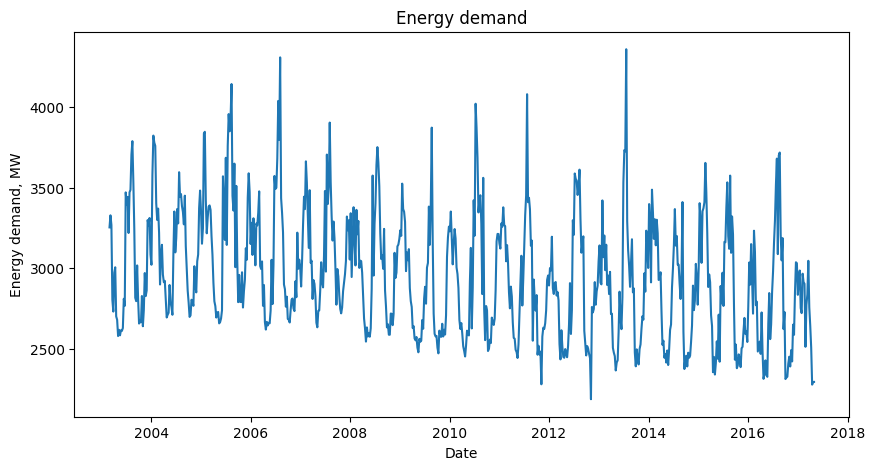

In [6]:
plot_energy_demand(data, scale=False)

## Perform Exploratory Data Analysis
Using techniques like autocorrelation plots, partial autocorrelation plots, and decomposition to further understand the time series data.
(This is more advanced)

## Cheatsheet for determining the number of lags

Here's a table for determining the number of lags to plot for ACF and PACF based on the frequency and domain type of your data. Note that the number of lags for ACF and PACF plots can be the same, but you may choose to adjust them based on the specific characteristics of your data.

| Frequency/Domain Type | Suggested Number of Lags for ACF & PACF |
|-----------------------|-----------------------------------------|
| Daily data            | 30                                      |
| Weekly data           | 52                                      |
| Monthly data          | 24                                      |
| Quarterly data        | 8                                       |
| Annual data           | 10                                      |
| Finance (e.g., stocks)| 20-30                                   |
| Climate (e.g., temperature) | 30-50                             |
| Macro-economics       | 10-20                                   |


/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.10/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


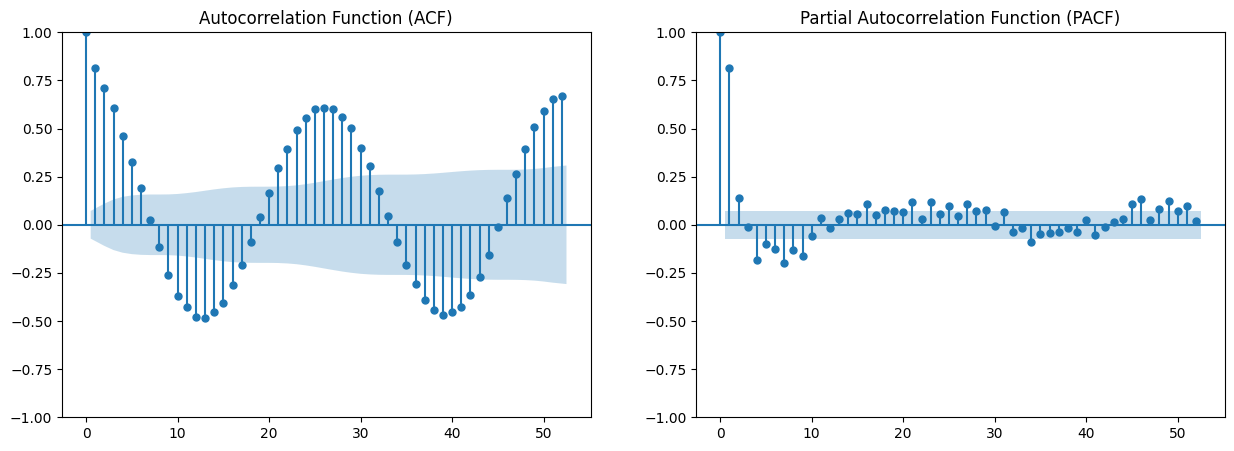

In [28]:
# Autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# what's the number of lags we want to plot?
number_of_lags = 52


# plot the autocorrelation and partial autocorrelation plots nicely side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(data, ax=ax1, lags=number_of_lags)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(data, ax=ax2, lags=number_of_lags)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.show()

## Cheat sheet for interpreting ACF and PACF plots

| Plot   | Pattern                                | Interpretation                             |
|--------|----------------------------------------|--------------------------------------------|
| ACF    | Gradual decline                        | Autoregressive (AR) component may be present |
| ACF    | Drops off quickly and remains near zero | Moving average (MA) component may be present |
| ACF    | Oscillating                            | Seasonal component may be present           |
| PACF   | Sharp drop after a certain lag         | AR component with an order equal to that lag |
| PACF   | Gradual decline                        | MA component may be present                |



When the ACF plot exhibits an oscillating pattern, it may indicate the presence of a seasonal component in the time series. In such cases, you may want to consider using a seasonal model (e.g., SARIMA) or a model that can capture seasonality (e.g., Facebook's Prophet, LSTM with seasonal input features).

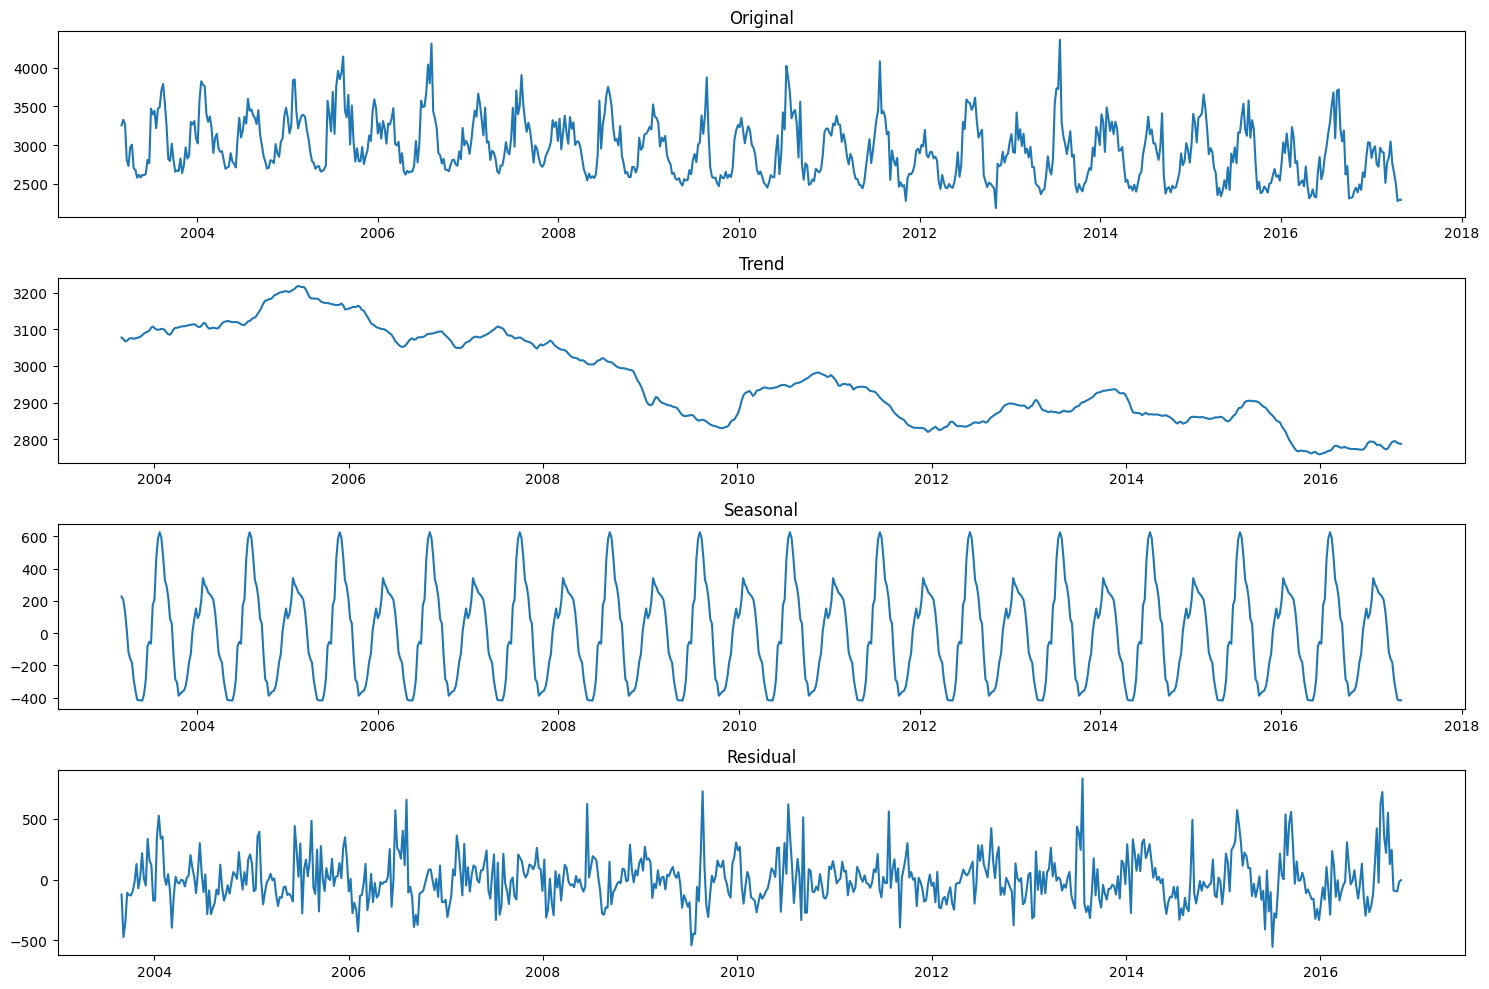

In [12]:
# Decomposing the time series - additive model

from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series
decomposition = seasonal_decompose(data, model="additive")

# plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
ax1.plot(data)
ax1.set_title("Original")
ax2.plot(decomposition.trend)
ax2.set_title("Trend")
ax3.plot(decomposition.seasonal)
ax3.set_title("Seasonal")
ax4.plot(decomposition.resid)
ax4.set_title("Residual")
plt.tight_layout()
plt.show()

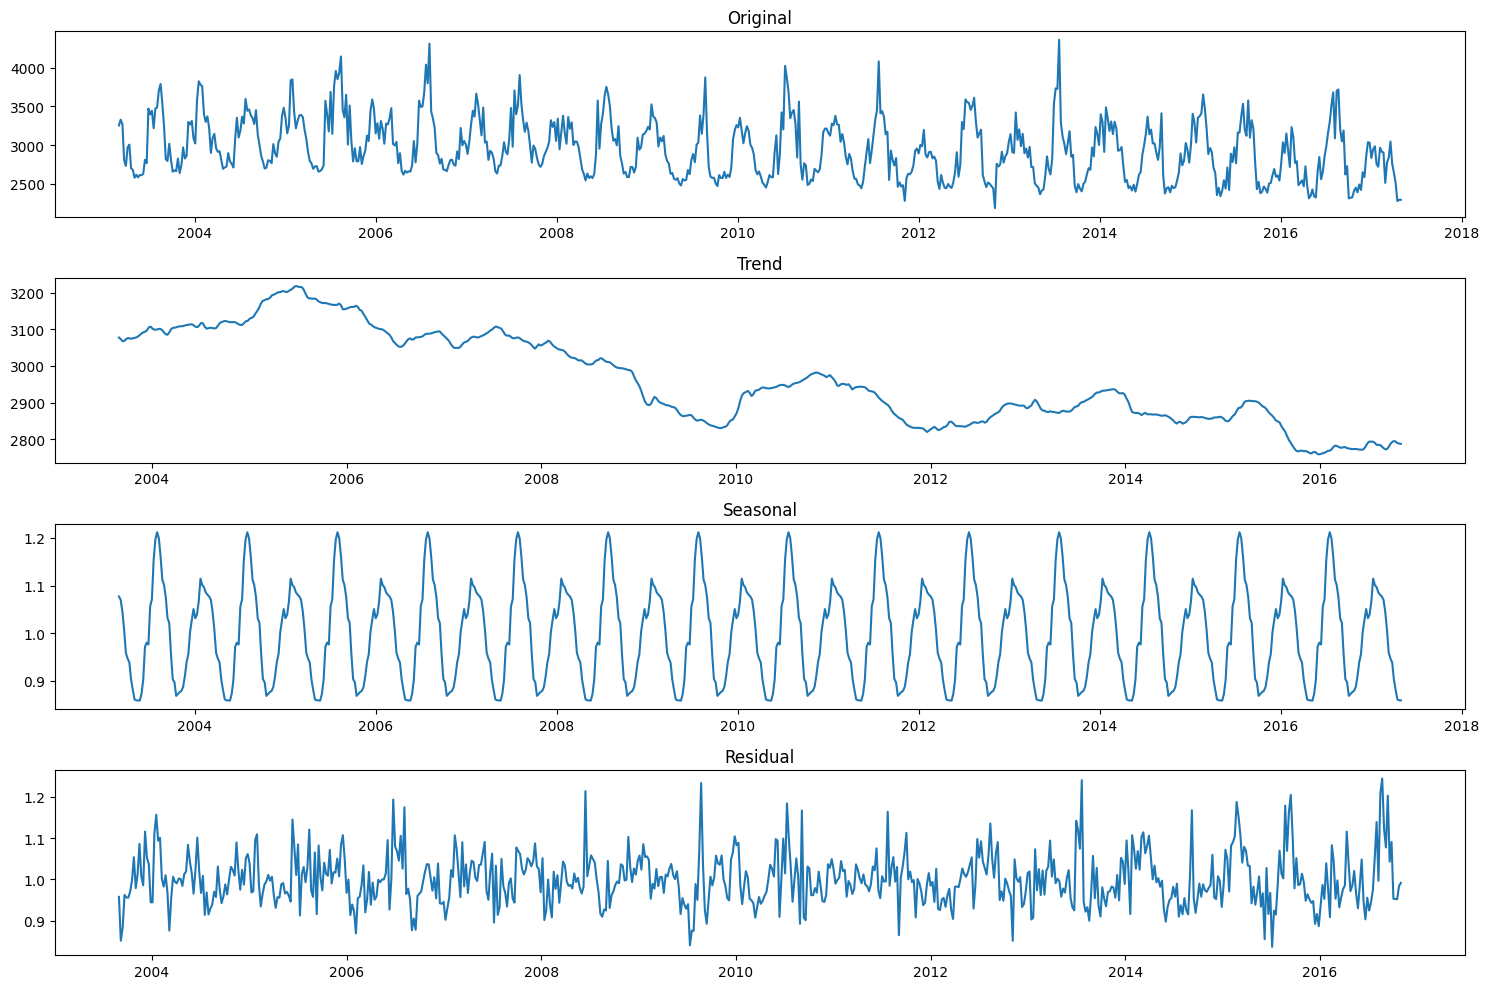

In [13]:
# Decomposing the time series - multiplicative model

# decompose the time series
decomposition = seasonal_decompose(data, model="multiplicative")

# plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
ax1.plot(data)
ax1.set_title("Original")
ax2.plot(decomposition.trend)
ax2.set_title("Trend")
ax3.plot(decomposition.seasonal)
ax3.set_title("Seasonal")
ax4.plot(decomposition.resid)
ax4.set_title("Residual")
plt.tight_layout()
plt.show()



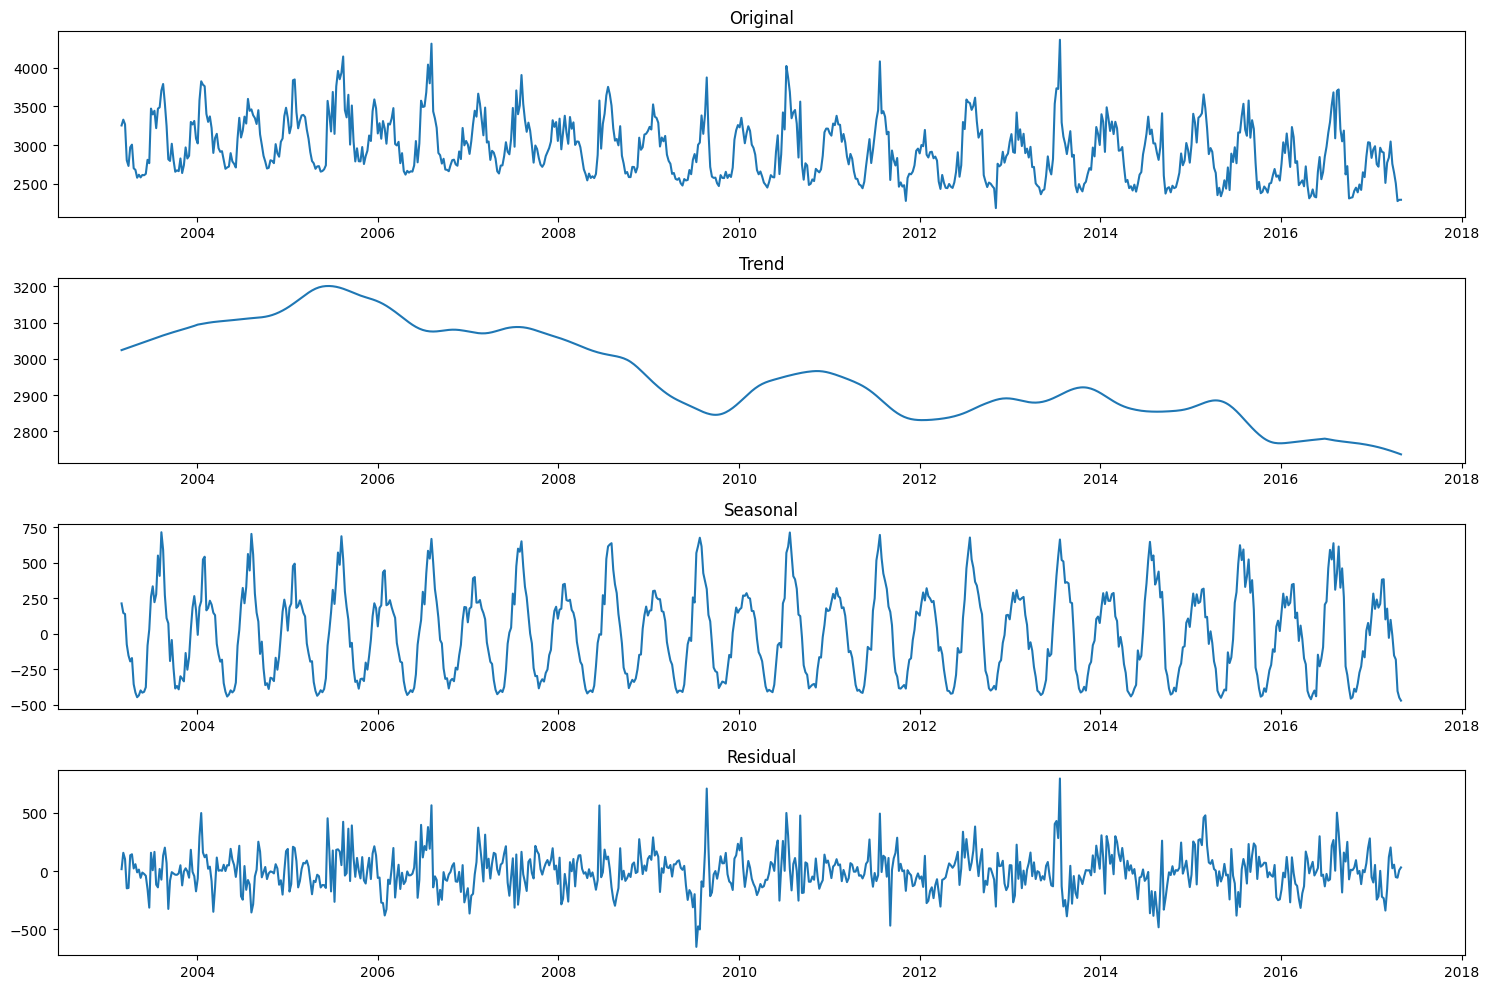

In [17]:
# Seasonal decomposition using the STL method

from statsmodels.tsa.seasonal import STL

# decompose the time series
decomposition = STL(data, seasonal=13).fit()

# plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
ax1.plot(data)
ax1.set_title("Original")
ax2.plot(decomposition.trend)
ax2.set_title("Trend")
ax3.plot(decomposition.seasonal)
ax3.set_title("Seasonal")
ax4.plot(decomposition.resid)
ax4.set_title("Residual")
plt.tight_layout()
plt.show()

